# Time Series Modeling

We'll start out with a pretty straight-forward situation and add complexity.
Inspiration from the guide here:
https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html#complicating-the-picture-further

and look at the pm.AR documentation here:
https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.AR.html




### Generate + Solve AR Process

We'll start with an autoregressive process

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

In [3]:
def sim_ar(intercept = 10, thetas = [-0.9,0.9], noise_var = 0.3, steps=500):
    X = np.zeros(steps)
    order = len(thetas) # by default it's 2; aka AR(2) process
    X[:order] = intercept
    for i in range(order, steps):
        X[i] = np.sum(thetas*np.flip(X[(i-order):i])) + np.random.normal(0, noise_var)
    return X
    

In [4]:
data = sim_ar(thetas = [-0.9,0.1])

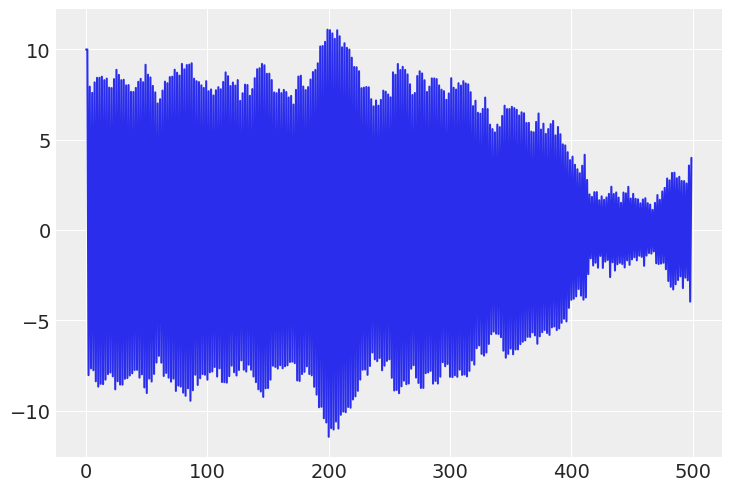

In [5]:
plt.plot(data)

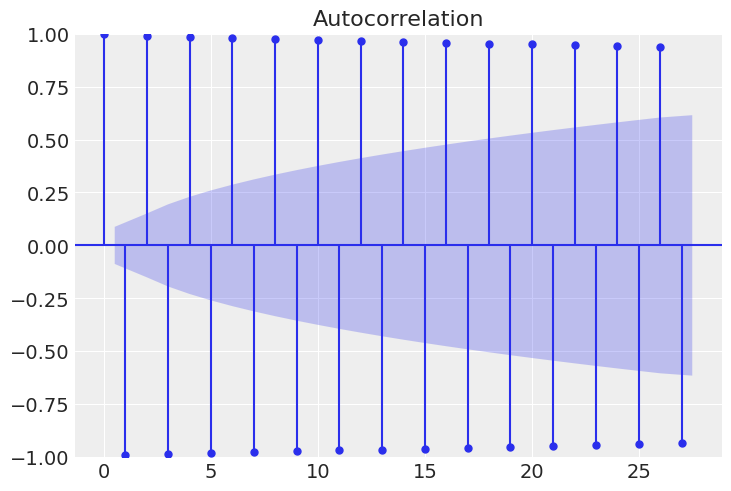

In [6]:
plot_acf(data)
plt.show()

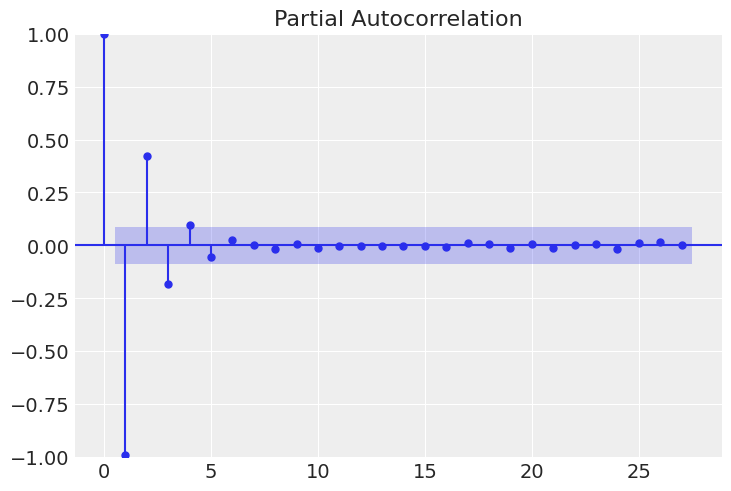

In [7]:
plot_pacf(data)
plt.show()

## Bayesian AR Model

Now, let's do some Bayesian modeling. 

In [10]:
# setting up dict of priors
priors = {
    "coefs": {"mu": [0, 0], "sigma": [1, 1], "size": 2},
    "sigma": 1,
    "init": {"mu": 10, "sigma": 3, "size": 2},
}
#conceit is we pretty much know the initial value;
# we need a prior each for each coefficient; here we'll go AR(2)

# split data into test and train
split = 300
data_train = data[0:split]
data_test = data[split:]
t_data = list(range(split))


In [11]:
with pm.Model() as AR:

    AR.add_coord("obs_id", t_data, mutable=True) # coords, mutable for prediction

    # data containers for time and 
    t = pm.MutableData("t", t_data, dims="obs_id")
    y = pm.MutableData("y", data_train, dims="obs_id")

    # now we build our priors for the AR model parameters

    # rho in the API, one per autoregression coefficient
    coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
    # standard deviation of our normal noise term
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    # We need one init variable for each lag, hence size is variable too
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )

    ar = pm.AR(
        "ar",
        coefs,
        sigma=sigma,
        init_dist=init,
        constant=False,
        dims="obs_id",
    )
    outcome = pm.Normal("likelihood", mu=ar, sigma=sigma, observed=y, dims="obs_id")

    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000, random_seed=100, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

Sampling: [ar, coefs, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma, ar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.
Sampling: [likelihood]


In [12]:
coefs

coefs ~ Normal(<constant>, <constant>)

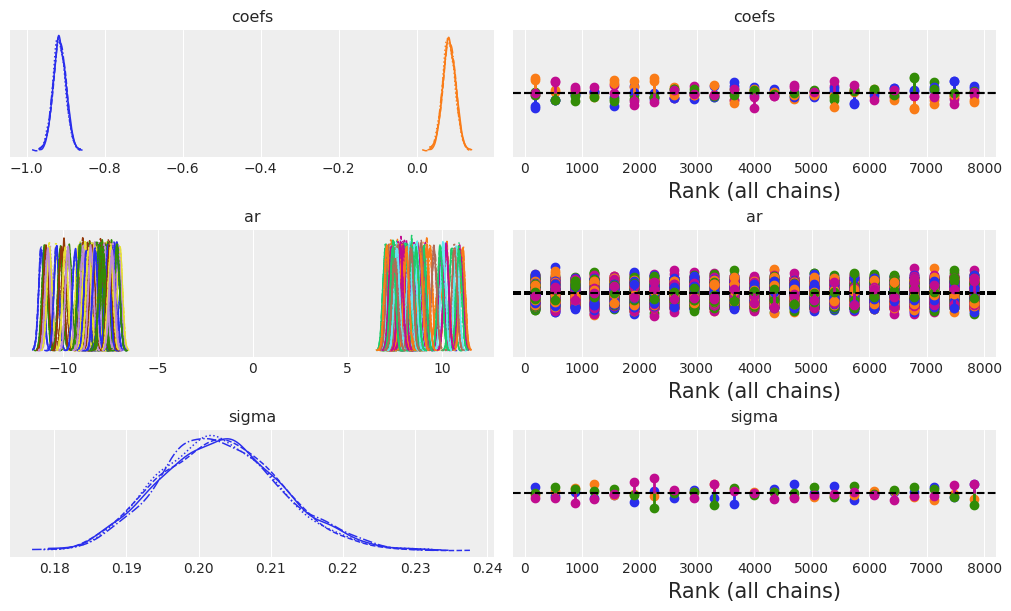

In [13]:
az.plot_trace(idata_ar, figsize=(10, 6), kind="rank_vlines"); # yup we did well!

In [14]:
az.summary(idata_ar, var_names=["~ar"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],-0.916,0.016,-0.949,-0.886,0.0,0.0,2884.0,4367.0,1.0
coefs[1],0.083,0.016,0.052,0.114,0.0,0.0,2869.0,4268.0,1.0
sigma,0.203,0.008,0.187,0.218,0.0,0.0,3857.0,5497.0,1.0


In [15]:
az.summary(idata_ar, var_names=["ar"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar[0],10.011,0.206,9.627,10.400,0.002,0.001,9747.0,6271.0,1.0
ar[1],9.833,0.200,9.443,10.194,0.003,0.002,5328.0,6279.0,1.0
ar[2],-8.009,0.171,-8.332,-7.687,0.002,0.002,4917.0,5737.0,1.0
ar[3],7.973,0.140,7.698,8.230,0.002,0.001,7735.0,6248.0,1.0
ar[4],-7.799,0.137,-8.061,-7.546,0.002,0.001,7634.0,6107.0,1.0
...,...,...,...,...,...,...,...,...,...
ar[295],7.592,0.135,7.339,7.842,0.002,0.001,7404.0,5599.0,1.0
ar[296],-7.507,0.138,-7.772,-7.258,0.002,0.001,8082.0,5956.0,1.0
ar[297],7.386,0.136,7.138,7.644,0.002,0.001,7697.0,6129.0,1.0
ar[298],-7.436,0.142,-7.698,-7.161,0.002,0.001,6943.0,5931.0,1.0


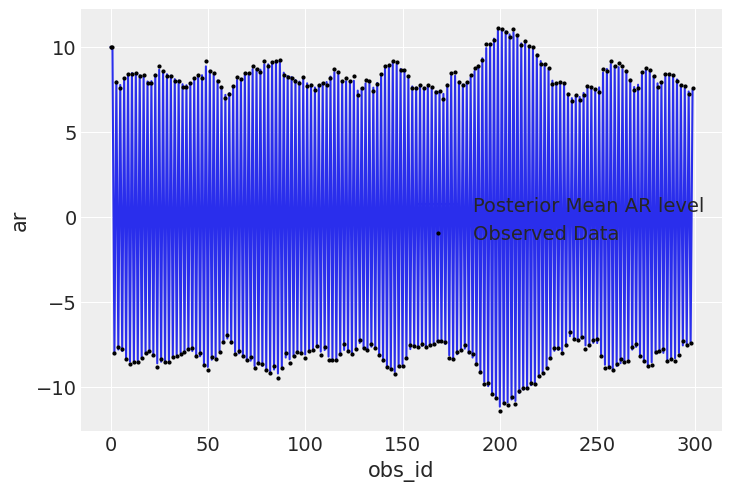

In [16]:
idata_ar.posterior.ar.mean(["chain", "draw"]).plot(label="Posterior Mean AR level")
plt.plot(data_train,'o',color="black", markersize=2, label="Observed Data")
plt.legend()

In [17]:
idata_ar

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

## Prediction Step

This method is pretty wonky. Since we have a two term lag we first have to create a new AR object with lag (meaning we need support over the last two values in the training data) and only then can we continue.

In [18]:

num_lags = priors["init"]["size"]
with AR:
    AR.add_coords({"obs_id_fut_lagged": range(len(data_train) - num_lags,len(data_test)+len(data_train),1 )})
    AR.add_coords({"obs_id_fut": range(len(data_train),len(data_test)+len(data_train),1 )})

    ar_fut = pm.AR(
        "ar_fut",
        init_dist=pm.DiracDelta.dist(ar[..., -num_lags]),
        rho=coefs,
        sigma=sigma,
        constant=False,
        dims="obs_id_fut_lagged",
    )

    yhat_fut = pm.Normal("yhat_fut", mu=ar_fut[num_lags:], sigma=sigma, dims="obs_id_fut")

    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(
        idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
    )

Sampling: [ar_fut, likelihood, yhat_fut]


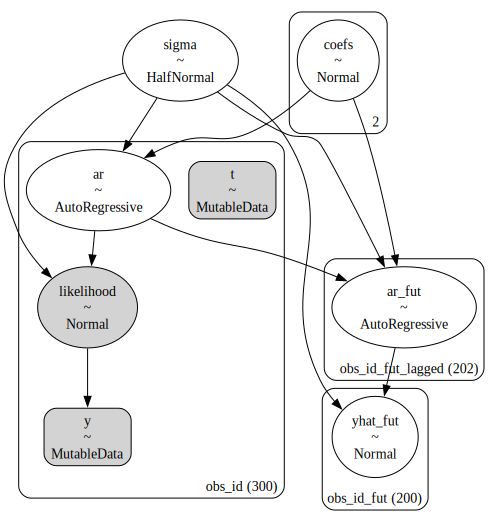

In [19]:
pm.model_to_graphviz(AR)

In [20]:
idata_preds.predictions

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 2000, obs_id: 300, obs_id_fut: 200)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * obs_id      (obs_id) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * obs_id_fut  (obs_id_fut) int64 300 301 302 303 304 ... 495 496 497 498 499
Data variables:
    likelihood  (chain, draw, obs_id) float64 10.02 9.707 ... -7.324 7.013
    yhat_fut    (chain, draw, obs_id_fut) float64 7.012 -6.842 ... 4.974 -5.067
Attributes:
    created_at:                 2024-09-14T18:16:01.976302
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.2

In [21]:
np.quantile(idata_preds.predictions.yhat_fut, 0.9)

7.430451962228059

In [22]:
np.quantile(idata_preds.predictions.yhat_fut, 0.8, axis=[0,1])

array([ 6.52205727, -5.94667739,  6.6589027 , -5.85568534,  6.7218446 ,
       -5.80082935,  6.76739534, -5.72723219,  6.81711764, -5.67634675,
        6.83948025, -5.6267217 ,  6.87522151, -5.5651559 ,  6.91104392,
       -5.53273876,  6.92539192, -5.47759025,  6.96494118, -5.45334102,
        6.98883264, -5.40377462,  7.01320722, -5.34768395,  7.04848256,
       -5.32663151,  7.06749553, -5.28784817,  7.11565178, -5.27429171,
        7.14488679, -5.22902144,  7.15829394, -5.18956746,  7.17911429,
       -5.13419718,  7.18578265, -5.11989934,  7.21117309, -5.11039341,
        7.22263595, -5.06600363,  7.23274862, -5.01475299,  7.2580815 ,
       -5.00548654,  7.24994891, -4.97578267,  7.25945962, -4.9189775 ,
        7.27821258, -4.90649215,  7.29749931, -4.86491598,  7.32751563,
       -4.80813507,  7.33483496, -4.79036683,  7.37766346, -4.7559116 ,
        7.37630927, -4.74128435,  7.36667288, -4.69318721,  7.38655834,
       -4.6961513 ,  7.42557715, -4.63629758,  7.39788708, -4.62

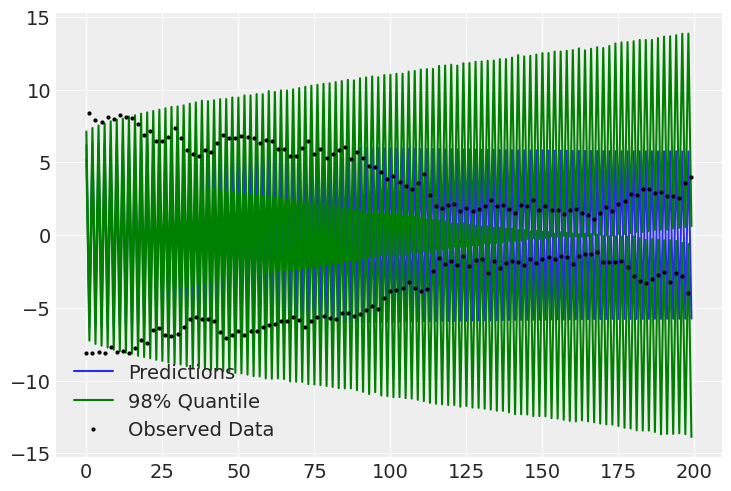

In [23]:
plt.plot(idata_preds.predictions.yhat_fut.mean(["chain", "draw"]), label="Predictions")
plt.plot(np.quantile(idata_preds.predictions.yhat_fut, 0.99, axis=[0,1]), color='green', label="98% Quantile")
plt.plot(np.quantile(idata_preds.predictions.yhat_fut, 0.01, axis=[0,1]), color='green')


plt.plot(data_test,'o',color="black", markersize=2, label="Observed Data")
plt.legend()

### Results Above

Well these results look fairly consistent with what they're getting on the tutorial (for different params and a slightly different model--I drop the intercept after initializing the ts leading to changes in things like the number of parameters). But I wouldn't call the results good. Real performance significantly steps outside of our intervals. That's probably to be expected; but I also am not totally sure the syntax is right here. When we pass "coefs" back in are we passing the posterior coefficients, or the priors we created earlier?

update: ok re-running with another random seed we avoided the appearance of this issue...but I'm still not sure this is the right way to do this.

Let's leave it for now...

## Time Series Projections With PyMC

I want to demonstrate to myself that we can run prediction forward in time by using the same parameters (this is a syntax issue not a theory issue). I'll do it by running a very simple linear regression, fitting it over a training range, and then extending to a test range


In [3]:
timesteps = 200
t = np.arange(timesteps)
theta = 5
noise = np.random.normal(0,20, timesteps)
y = theta*t + noise

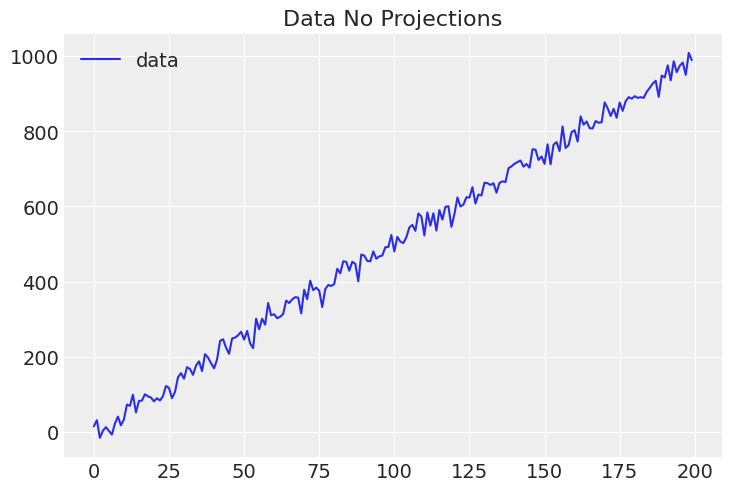

In [12]:
plt.plot(t, y, label="data")
plt.title("Data No Projections")
plt.legend()

In [5]:
with pm.Model() as linmod:
    linmod.add_coords({"obs_id": range(timesteps)})
    
    time = pm.MutableData("t", t, dims="obs_id")
    vals = pm.MutableData("y", y, dims="obs_id")
    params = pm.Normal("params", 0,10)
    sigma = pm.HalfNormal("sigma", 5)
    mu = params*time
    obs = pm.Normal("obs", mu, sigma, observed=vals, dims="obs_id")


    #trace = pm.sample(draws=1000,tune=1000)
    

In [10]:
#trace.posterior.params 
# yup so we were able to converge on the right answer here
# later tried seeing if it works if I don't run the original sample

In [7]:
projection_steps = 200
with linmod:
    linmod.add_coords({"obs_id_fut": range(timesteps,timesteps+projection_steps,1 )})

    t_fut = pm.MutableData(
        "t_fut", list(range(timesteps, timesteps+projection_steps, 1)), dims="obs_id_fut"
    )
    mu = pm.Deterministic("mu_fut", params * t_fut, dims="obs_id_fut")
    yhat_fut = pm.Normal("yhat_fut", mu=mu, sigma=sigma, dims="obs_id_fut")

    trace_future = pm.sample(draws=1000,tune=1000)

    # use the updated values and predict outcomes and probabilities:
    trace_future =  pm.sample(draws=1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [params, sigma, yhat_fut]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [params, sigma, yhat_fut]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


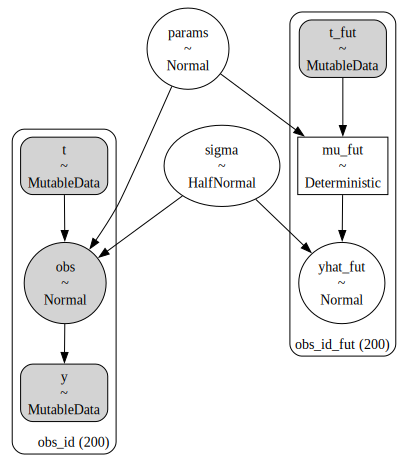

In [8]:
pm.model_to_graphviz(linmod)

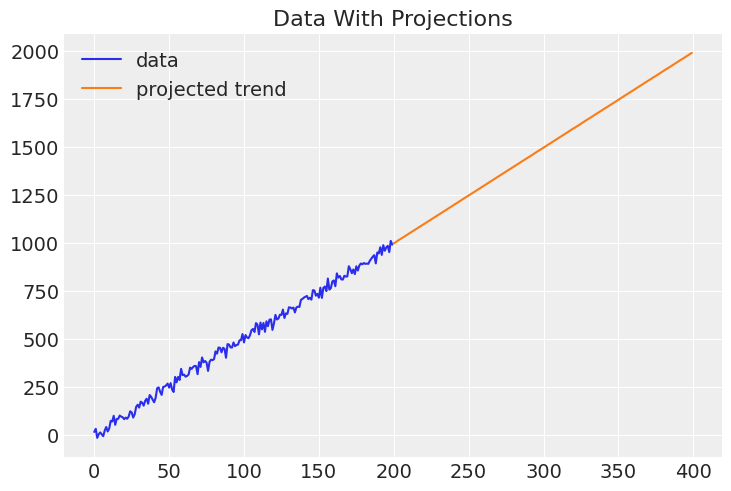

In [13]:
plt.plot(t,y, label='data')
plt.plot(np.arange(timesteps, timesteps+projection_steps,1), trace_future.posterior.yhat_fut.mean(['chain','draw']), label='projected trend')
plt.title('Data With Projections')
plt.legend()

## Conclusion

Ok, I believe it now. The syntax works just fine. We're able to use the same parameters (that we originally set to some prior) and when we project with them we'll use the posterior fit we arrive at in the end. If I was using my prior for theta here I'd see a flat line because the prior was N(0,10). Instead, we're clearly using the posterior slope which is 5. 